In [1]:
#import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('n')

n


Need to create an LTI simulator

In [2]:
np.random.multivariate_normal(mean = np.zeros(2),cov=np.eye(2)).shape

(2,)

In [280]:
class LTISimulator(object):
    def __init__(self,A,B,C,covW,covZ,x_init): 
        self.A = A
        self.B = B
        self.C = C
        self.covW = covW
        self.covZ= covZ
        self.x = [x_init]
        self.state = x_init
        self.measurement = np.zeros(1)
        self.zs = []
        self.ws = []
        
        z = np.random.multivariate_normal(mean = np.zeros(self.C.shape[0]),cov=self.covZ)
        self.zs.append(z)
        
        self.measurement = self.C.dot(self.state+z)
        self.y = [self.measurement]
    
    def simulate(self,u):
        self.u = u
        
        for i in range(len(u)):
            w = np.random.multivariate_normal(mean = np.zeros(self.A.shape[0]),cov= self.covW)
            self.state = self.A.dot(self.state) + self.B.dot(u[i]).flatten() + w
            
            self.ws.append(w)
            
            self.x.append(self.state)
            z = np.random.multivariate_normal(mean = np.zeros(self.C.shape[0]),cov = self.covZ)
            
            self.measurement = self.C.dot(self.state)+z

            
            self.y.append(self.measurement)
    

In [4]:
def SolveDTRicatti(A,B,Q,R,tol = 1e-5):
    #we will need this to both implement control
    #and to estimate parameters for the system
    P = np.copy(Q)
    
    if np.max(np.linalg.eigvals(A).real) > 1:
        print('This matrix is not stable, we cannot solve for the optimal controller using iteration. Try decomposing a symplectic matrix.')
        return 1
    
    while True:
        
        Pnew = Q +A.T.dot(P.dot(A)) - (A.T.dot(P.dot(B))).dot(np.linalg.inv(R+B.T.dot(P.dot(B)))).dot(B.T.dot(P.dot(A)))
        if np.linalg.norm(P-Pnew) <tol:
            break
        else:
            P = Pnew
    
    return Pnew


In [36]:
A = np.array([[.8,.94],[.25,-.83]])
A/=10
np.linalg.eigvals(A)

#this is actually a stable matrix, let's just stick with this for testing our stuff

# B = np.array([[1],[.2]])
# Q = .1*np.eye(2)
# R = np.array([.05])

# P = SolveDTRicatti(A,B,Q,R,tol = 1e-5)

array([ 0.09332747, -0.09632747])

In [238]:
def FIRCoefficientSolver(y,u,H):
    #here we implement least squares on outputs, inputs and other outputs
    #this assumes that we consider the system represented by the "observer form"
    #or in other words a kalman filter in steady state
    
    assert len(y) > H
    
    #create outputs
    y_train = y[H:]
    x_train = np.zeros((len(y_train),2*H))
    
    for i in range(len(y_train)):
        x_train[i,:H] = np.flip(u[i:i+H])
        x_train[i,H:] = np.flip(y[i:i+H]).flatten()
    
    FIRCoeffs = np.linalg.inv(x_train.T.dot(x_train)+10*np.eye(x_train.shape[1])).dot(x_train.T.dot(y_train))
    
#     plt.figure()
#     plt.plot(x_train.dot(FIRCoeffs)[:20])
#     plt.plot(y_train[:20])
#     plt.show()
    #okay so that's doing the right thing
    return FIRCoeffs

#now we need to recover estimates in the system

def HoKalman(H,n,input_dim,output_dim):
    u,s,vh = np.linalg.svd(H)
    
    smat = np.sqrt(np.diag(s))[:n,:n]
    
    D1 = u[:,:n].dot(smat)
    D2 = smat.dot(vh[:n,:])
    
    Chat = D1[:output_dim,:]
    Bhat = D2[:,input_dim]
    
    
    Dminus = D1[:n-output_dim,:]
    Dplus = D1[output_dim:n,:]
    
    Ahat = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
    
    return Ahat,Bhat,Chat
    
    
    
    
def return_LTI_coeffs(FIRCoeffs,H,k,n):
    #implement the ho kalman algorithm twice
    #note that this algorithm assume a SISO system otherwise more complicated indexing will be required
    
    FIR1 = FIRCoeffs[:H]
    FIR2 = FIRCoeffs[H:]
    
    Hmat = []
    i = 0
    while True:
        Hmat.append(np.array(list(FIR1[i:k+i])+list(FIR2[i:k+i])))
        
        i+=1
        if k+i >=H:
            break
    
            
    Hmat = np.array(Hmat)
    Hmat = Hmat.reshape(Hmat.shape[0],Hmat.shape[1])
    print(Hmat.shape)
    
    u,s,vh= np.linalg.svd(Hmat)
    
    smat = np.sqrt(np.diag(s))[:n,:n]
    
    u = u[:,:n]
    vh = vh[:n,:]
    
    D1 = u.dot(smat)
    D2 = smat.dot(vh)
    
    Chat = D1[:1,:]
    Bhat = D2[:,:1]
    
    Fhat = D2[:,k]
    
    Dminus = D1[:n-1,:]
    Dplus = D1[1:n,:]
    
    Ahatbar = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
    
    
    Ahat = Ahatbar+ Fhat.reshape(-1,1).dot(Chat)
#     Ahat /= (np.max(np.abs(np.linalg.eigvals(Ahat)))*1.001)
    
    return Ahat,Bhat,Chat,Fhat
    
    

In [239]:
#okay so now we need to test this system. Use existing value for A, B
C = np.array([[1,0]])

C.dot(np.ones(2))
B = np.array([1,2]).reshape(-1,1)


In [259]:
LTISim = LTISimulator(A,B,C,.1*np.eye(5),.001*np.eye(1),x_init = np.zeros(5))

In [260]:
u = np.random.normal(size = 10000)
LTISim.simulate(u)


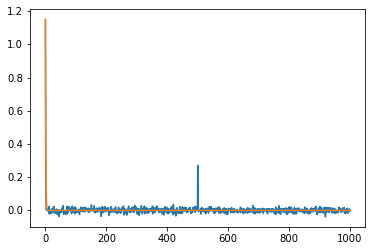

[ 4.33259999e-01+0.j          3.19519157e-02+0.04503254j
  3.19519157e-02-0.04503254j -6.69220680e-02+0.j
  3.74512676e-04+0.j        ]


In [289]:
#okay now let's see how our hankel estimation works:
FIRCoeffs = FIRCoefficientSolver(LTISim.y,u,H=500)
plt.figure()
plt.plot(FIRCoeffs)
trueFIR = []
for i in range(len(FIRCoeffs)):
    trueFIR.append(C.dot(np.linalg.matrix_power(A,i).dot(B))[0,0])

plt.plot(trueFIR)
plt.show()


Ahat,Bhat,Chat = HoKalmanObserverForm(FIRCoeffs,H=500,k=100,n=5)
print(np.linalg.eigvals(Ahat))

In [295]:
print(np.linalg.eigvals(A))
print(np.linalg.eigvals(Ahat))
Chat = Chat.reshape(-1,1)
Chat = Chat.T
Chat.shape



[ 4.33259999e-01+0.j         -6.69220681e-02+0.j
  3.19519157e-02+0.04503254j  3.19519157e-02-0.04503254j
  3.74512684e-04+0.j        ]
[ 4.33259999e-01+0.j          3.19519157e-02+0.04503254j
  3.19519157e-02-0.04503254j -6.69220680e-02+0.j
  3.74512676e-04+0.j        ]
[[-0.35566477  0.1070948   0.13529015  0.11974219  0.03120376]
 [ 0.11424696  0.31056791 -0.15844377  0.12615386  0.14165807]
 [-0.00699174  0.52566097 -0.2230239   0.00818427  0.03610501]
 [ 0.03667041  0.06677931  0.13923484  0.18772123 -0.01538029]
 [ 0.12237061  0.02785522  0.05816895  0.14689849  0.08039952]]


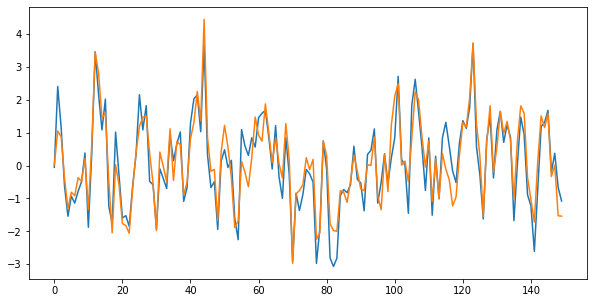

In [291]:
LTISim2 = LTISimulator(Ahat,Bhat,Chat,.0001*np.eye(5),.001*np.eye(1),x_init = np.zeros(5))
LTISim2.simulate(u)


plt.figure(figsize = (10,5))
plt.plot(LTISim.y[:150])
plt.plot(LTISim2.y[:150])
plt.show()

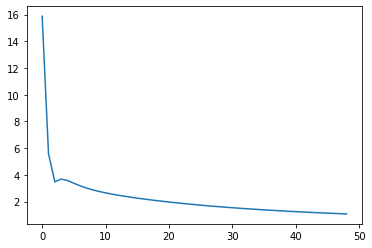

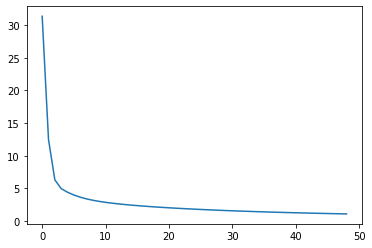

In [294]:
#maybe an easier way to measure similarity is through a bode plot



def bode_plot(A,B,C,rng = 20):
    
    def func(A,B,C,z):
        return np.abs(C.dot(np.linalg.inv(z*np.eye(A.shape[0])-A).dot(B)))[0]
    
    jwvals = np.linspace(0,rng,1000)
    yvals = []
    for v in jwvals:
        yvals.append(func(A,B,C,1j*v))
        
    
    plt.figure()
    plt.plot(yvals[1:50])
    plt.show()

bode_plot(Ahat,Bhat,Chat)
bode_plot(A,B,C)


#so indeed, sometimes this approach actually works. I wonder what Fhat is

In [214]:
#is the kalman ho algorithm working as expected?

# hankelmat = np.zeros((200,200))

A = np.array([[.94,.0225],[.1,.89]])
print(np.linalg.eigvals(A))

# for i in range(200):
#     for j in range(200):
#         hankelmat[i,j] = C.dot(np.linalg.matrix_power(A,i+j).dot(B))
        
# m1,m2,m3 = HoKalman(hankelmat,2,1,1)
# print(np.linalg.eigvals(m1))

#this is bad! the eigenvalues that are recovered from this matrix should be bounded by 1.


[0.96861903 0.86138097]


In [185]:


#interesting so that's not zero as suggested by Munzer. 

array([-0.39843456, -0.0658244 ])

In [287]:
#let's see if we can't recode ho kalman to give proper results:
np.random.seed(42)

A= np.random.rand(5,5)/5

B = np.random.rand(5,1)
C = np.random.rand(1,5)

#let's construct a hankel matrix
# np.linalg.matrix_power(A,0)

# h = np.zeros((1000,1000))
# for i in range(1000):
#     for j in range(1000):
#         h[i,j] = C.dot(np.linalg.matrix_power(A,i+j).dot(B))



def Hokalman2(H,n):
    
    u,s,vh = np.linalg.svd(H)
    
    smat = np.sqrt(np.diag(s))
    smat = smat[:n,:n]
    D1 = u[:,:n].dot(smat)
    D2 = smat.dot(vh[:n,:])
    
    Cest = D1[0,:]
    Best = D2[:,0]
    
    Dminus = D2[:,:D2.shape[1]-1].T
    Dplus = D2[:,1:D2.shape[1]].T
    
    #then we have A*Dminus = Dplus
    #or in other words Dminus^T A^T = Dplus.T right?
    #so then the least squares solution should be 
    Aest = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
    Aest = Aest.T
    return Aest,Best,Cest

def HoKalmanObserverForm(FIRCoeff,H,k,n):
    #here H is the size of the FIR coefficients
    #k is the dimension of the constructed hankel matrix
    #n is the best guess for the dimension of the system
    
    FIR1 = FIRCoeffs[:H]
    FIR2 = FIRCoeffs[H:]
    
    
    Hmat = np.zeros((k,2*k))
    
    assert 2*k < H, 'Pick a smaller hankel size'
    
    for i in range(k):
        for j in range(k):
            Hmat[i,j] = FIR1[i+j]
    
    for i in range(k):
        for j in range(k):
            Hmat[i,j+k] = FIR2[i+j]
            
    Hmat = Hmat[:,:k]
            
            
    u,s,vh = np.linalg.svd(Hmat)
    
    smat = np.sqrt(np.diag(s))
    smat = smat[:n,:n]
    D1 = u[:,:n].dot(smat)
    D2 = smat.dot(vh[:n,:])
    
    Cest = D1[0,:]
    Best = D2[:,0]
#     Fest = D2[:,k]
    
    Dminus = D2[:,:D2.shape[1]-1].T
    Dplus = D2[:,1:D2.shape[1]].T
    
    Ahatest = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
    Ahatest = Ahatest.T
    
#     Aest = Ahatest+np.outer(Fest,Cest)
    Ahat = Ahatest
    
    return Aest,Best,Cest#,Fest
    
    
    
    
    
    
# Aest,Best,Cest = Hokalman2(h,5)

print(np.linalg.eigvals(A))
# print(np.linalg.eigvals(Aest))

[ 4.33259999e-01+0.j         -6.69220681e-02+0.j
  3.19519157e-02+0.04503254j  3.19519157e-02-0.04503254j
  3.74512684e-04+0.j        ]


In [311]:
from scipy.optimize import rosen, rosen_der
from ipopt import minimize_ipopt

def dummyFunc(x):
    return (np.sin(1/x[0])*2*np.cos(1/x[1])*np.cos(1/x[2]))**2


x0 = [1.3, 0.7, 0.9]
res = minimize_ipopt(dummyFunc, x0)
print(res)






     fun: 5.039584905997163e-17
    info: {'x': array([1.30462132, 0.63661977, 0.88074357]), 'g': array([], dtype=float64), 'obj_val': 5.039584905997163e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0.]), 'mult_x_U': array([0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 12
     nit: 6
    njev: 8
  status: 0
 success: True
       x: array([1.30462132, 0.63661977, 0.88074357])


In [490]:
def CalculateNaturesYs(Ahat,Bhat,Chat,w,z,t):
    #assume that x0= 0 then calculate the impact of nature
    assert t<= len(w)
    if t ==0:   
        b = z[0] 
    else:
        b = 0
        for i in range(t):
            b+= Chat.dot(np.linalg.matrix_power(Ahat,i))*w[:,t-i]
        b +=z[t]
        
    return b

# def ObjectiveFunction(M):
#     #these are all constants that are already specified before calling the optimization:
#     # Q,R,Ahat,Bhat,Chat,w,z
#     #here M is a sequence of H' number (approximating FIR coefficients..)
#     bs = []
#     for i in range(len(w)):
#         bs.append(CalculateNaturesYs(Ahat,Bhat,Chat,W,z,t))
        
#     ys = []
#     us = []
#     for i in range(len(w)):
#         #need to calculate 
#         u = 0
#         for j in range(min([len(M),i])):
# #             u = bs[i-j]* #should be a convolution..
        
        
    
        
        
        
    #we actually want to optimize over a tensor M with shape (1,1,H'). In our case we will just use the scalar case.
    
    
def CalculateControl(b,M):
    
    u = []
    for i in range(len(b)):
        utmp = 0
        for j in range(min([i,len(M)])):
            utmp = b[i-j]*M[j]
        u.append(utmp)

    return u

    

def CalculateB(Aest,Best,Cest,w,z):
    
    b = [z[0]] #assuming that x0= 0
#     assert len(z) == len(w)+1
    
    for i in range(w.shape[1]):
        btmp = z[i]
        for j in range(i):
            btmp += Cest.dot(np.linalg.matrix_power(Aest,j)).dot(w[:,i-j])
        b.append(btmp)
        
    
    return b

def optimizeControl(M,Aest,Best,Cest,w,z,q,r):
    
    #need to calculate natures ys
    b = CalculateB(Aest,Best,Cest,w,z)
    def objective(M):
        u = CalculateControl(b,M)
        #assuming that x0= 0 we can calculate the state trajectory
        yu = []
        for i in range(len(b)):
            ytmp = 0
            for j in range(i):
                ytmp += Cest.dot(np.linalg.matrix_power(Aest,j).dot(Best))[0,0]*u[i-j]
            ytmp+=b[i]
            yu.append(ytmp)
            
        yu = np.array(yu)
        
        objval = 0
        for i in range(len(u)):
            objval+=q*(yu[i]**2)+r*(u[i]**2)
        objval+=q*(yu[-1]**2)
        
        return objval
    
    def calculate_gradient(M,eps = .0005,):
        grad = np.zeros(len(M))
        for i in range(len(M)):
            Mnew = np.copy(M)
            Mnew[i]+=eps
            grad[i] = objective(Mnew)-objective(M)
            
        grad/=eps
        
        return grad
    
    def gradient_ascent(M,steps,stepsize):
        obj = objective(M)
        for i in range(steps):
            grad = calculate_gradient(M)
            grad += .005*(np.random.rand(len(M))-.5)
            Mnew=M - stepsize*np.random.rand()*grad
            objnew = objective(Mnew)
            if objnew < obj:
                print('improved by '+str(obj-objnew))
                M=Mnew
                obj = objnew
        return M
    
    res = minimize_ipopt(objective, M)
    Mnew = res.x
    print(res)
    
    Mgrad = gradient_ascent(Mnew+(np.random.rand(len(M))-.5),500,.005)
    print(objective(Mgrad))
    
    return Mnew,Mgrad
    
    
    
        
        
    

In [491]:
#gotta make sure the dimensions work out. 
np.random.seed(42)
A1 = np.random.rand(2,2)/1.33
B1 = np.random.rand(2,1)
C1 = np.random.rand(1,2)
M1 = np.random.rand(3)
w = np.random.multivariate_normal(mean = np.zeros(2),cov = np.eye(2),size = 40).T
z = np.random.rand(41)
q = 10
r = 1

print(np.linalg.eigvals(A1))



[-0.26699992  0.99872819]


In [492]:
M100,Mgrad = optimizeControl(M1,A1,B1,C1,w,z,q,r)

     fun: 583.6604049756145
    info: {'x': array([30.14112749, 37.91182058,  0.11492098]), 'g': array([], dtype=float64), 'obj_val': 583.6604049756145, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0.]), 'mult_x_U': array([0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 613
     nit: 164
    njev: 166
  status: 0
 success: True
       x: array([30.14112749, 37.91182058,  0.11492098])
improved by [170.70358359]
improved by [11.95370764]
improved by [11.26851553]
improved by [9.62367479]
improved by [0.73896056]
improved by [0.33688501]
improved by [0.02897213]
[583.66587043]


[ 2.23410655  2.40173226 -0.26097801]


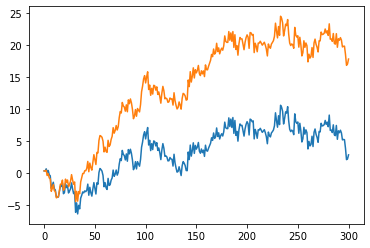

In [478]:
#okay so now how do we compare the two trajectories? and does this M actually stabilize the system??
#let's try er out...

#b =CalculateB(Aest,Best,Cest,w,z)
#u = CalculateControl(b,M)

wnew = np.random.multivariate_normal(mean = np.zeros(2),cov = np.eye(2),size = 300).T
znew = np.random.rand(301)

def calculateTrajectory(Aest,Best,Cest,w,z,M):
    
    n= w.shape[1]
    
    b = CalculateB(Aest,Best,Cest,w,z)
    u = CalculateControl(b,M)
    
    #calculate trajectory...
    
    ys = [z[0]]
    for i in range(w.shape[1]):
        #state at time i should be natures y plus the effect of control
        tmpstate = 0
        for j in range(i):
            tmpstate += Cest.dot(np.linalg.matrix_power(Aest,j).dot(Best))[0,0]*u[i-j]
            
        ys.append(b[i]+tmpstate)
    
    return(ys)
print(Mgrad)
plt.plot(calculateTrajectory(A1,B1,C1,wnew,znew,M100))
plt.plot(calculateTrajectory(A1,B1,C1,wnew,znew,Mgrad))
